In [1]:
import argparse
import numpy as np
import random
import torch
from systems_pbc import *
import torch.backends.cudnn as cudnn
from utils import *
from visualize import *
import matplotlib.pyplot as plt
from models import FNN3d
from train_utils import Adam
from tqdm import tqdm
from train_utils.losses import GeoPC_loss
import matplotlib.image as pm
import torch.nn as nn
# from mpl_toolkits.basemap import Basemap
import tifffile
from data_ import utils
import scipy.ndimage
import boundary
import boundary_gt
from PIL import Image
from pyMesh import visualize2D, setAxisLabel
import train_utils.tensorboard as tb
from AWL import AutomaticWeightedLoss
import torch.nn.functional as F
from hydraulics import saint_venant
from scipy import interpolate
from matplotlib.colors import ListedColormap
# from skimage.transform import resize
from train_utils.losses import *
from torch.utils.data import DataLoader
from pyMesh import visualize2D
import imageio
import io
import os
import tifffile as tiff
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
gpu_ids = [0]
output_device = gpu_ids[0]
Root_path='/home/sirui/INNOMAUS/'##################### please change the path to your local path !!! ###################
################
# Arguments
################
class Args:
    def __init__(self):
        # Basic configuration
        self.loss_style = 'mean'  # Loss for the network (MSE vs. summing)
        self.visualize = True  # Visualize the solution
        self.save_model = True  # Save the model for analysis later

        # PINO_model configuration
        self.layers = [16, 24, 24, 32, 32]  # Dimensions/layers of the NN
        self.modes1 = [32, 32, 32, 32]  # Modes for first dimension
        self.modes2 = [32, 32, 32, 32]  # Modes for second dimension
        self.modes3 = [8, 8, 8, 8]  # Modes for third dimension
        self.fc_dim = 128  # Fully connected layer dimension
        self.epochs = 15000  # Number of epochs
        self.activation = 'gelu'  # Activation function to use in the network

        # Training configuration
        self.base_lr = 0.001  # Learning rate
        self.milestones = [500, 1000, 2000, 3000, 4000, 5000]  # Milestones for learning rate scheduler
        self.scheduler_gamma = 0.5  # Gamma for learning rate scheduler
        self.theta = 0.7  # q-centered weighting. [0,1]

    def __str__(self):
        return (f'Args(loss_style={self.loss_style}, visualize={self.visualize}, save_model={self.save_model}, '
                f'layers={self.layers}, modes1={self.modes1}, modes2={self.modes2}, modes3={self.modes3}, '
                f'fc_dim={self.fc_dim}, epochs={self.epochs}, activation={self.activation}, '
                f'base_lr={self.base_lr}, milestones={self.milestones}, scheduler_gamma={self.scheduler_gamma}, '
                f'theta={self.theta})')

# Example of how to use the Args class:
args = Args()

# Accessing an attribute
print("Layers:", args.layers)

# Print all arguments
print(args)

import sys

# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)
else:
    device = torch.device('cpu')
    print(device)
#device = torch.device('cpu')
#output_device=device
print(device)

Layers: [16, 24, 24, 32, 32]
Args(loss_style=mean, visualize=True, save_model=True, layers=[16, 24, 24, 32, 32], modes1=[32, 32, 32, 32], modes2=[32, 32, 32, 32], modes3=[8, 8, 8, 8], fc_dim=128, epochs=15000, activation=gelu, base_lr=0.001, milestones=[500, 1000, 2000, 3000, 4000, 5000], scheduler_gamma=0.5, theta=0.7)
cuda
cuda


In [2]:
############################
# Process data
###########################
def inter(array, size):
    h, w = array.shape
    new_h, new_w = np.floor_divide((h, w), size)
    x = np.linspace(0, w - 1, w)
    y = np.linspace(0, h - 1, h)
    new_x = np.linspace(0, w - 1, new_w)
    new_y = np.linspace(0, h - 1, new_h)
    f = interpolate.interp2d(x, y, array, kind='linear')
    array_down = f(new_x, new_y)
    # array_down = resize(array, (new_h, new_w), order=1, anti_aliasing=True)
    return array_down
def find_non_zero_in_kernel(kernel):
    """
    Find the nearest non-zero element in a given kernel (block of pixels).
    If no non-zero value is found, return 0.
    """
    non_zero_elements = kernel[kernel != 0]
    if len(non_zero_elements) > 0:
        # Return the first non-zero element found (or nearest if required)
        return np.mean(non_zero_elements)
    else:
        return 0  # Return zero if no non-zero elements are found

def resize_with_kernel_nearest_non_zero(array, downsample_factor):
    """
    Resize the array by downsampling by `downsample_factor` (e.g., 6x6 blocks).
    Each downsampled pixel is assigned the nearest non-zero element from its kernel.
    """
    h, w = array.shape
    new_h = h // downsample_factor
    new_w = w // downsample_factor
    
    # Initialize the downsampled array
    result = np.zeros((new_h, new_w), dtype=array.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            # Extract the 6x6 block (or downsample_factor x downsample_factor block)
            y_start = i * downsample_factor
            y_end = min((i + 1) * downsample_factor, h)
            x_start = j * downsample_factor
            x_end = min((j + 1) * downsample_factor, w)
            
            # Get the block of the original array
            kernel = array[y_start:y_end, x_start:x_end]
            
            # Find the nearest non-zero value in the kernel
            result[i, j] = find_non_zero_in_kernel(kernel)
    
    return result

def inter2(array, size):
    h, w = array.shape
    new_h, new_w = np.floor_divide((h, w), size)
    x = np.linspace(0, w - 1, w)
    y = np.linspace(0, h - 1, h)
    new_x = np.linspace(0, w - 1, new_w)
    new_y = np.linspace(0, h - 1, new_h)
    target_size=size
    # Ensure the target size is a downsampling factor, e.g., (6, 6)
    if isinstance(target_size, (tuple, list)) and len(target_size) == 2:
        downsample_factor = target_size[0]  # Assuming square downsample blocks
    else:
        downsample_factor = target_size  # Single integer value
    
    # Perform the resizing with nearest non-zero from kernels
    array_down = resize_with_kernel_nearest_non_zero(array, downsample_factor)
    return array_down
def process_dem(dem_map):
    np_ma_map = np.ma.masked_array(dem_map, mask=(dem_map < -2000))
    np_ma_map = utils.fix_missing_values(np_ma_map)
    dem = torch.from_numpy(np_ma_map)
    return dem.float()
# Parameters
g = torch.tensor(9.80616, dtype=torch.float64)
dem_tif_path = Root_path+'data/output/115mm/r2d_bln1_swmm_b_115mm_0H.tif'#
input_path = Root_path+'data/output'# Here we put 20 training events for ground truth. but in this file, we don't load the data in this folder
imput_path_val = Root_path+'data/val'# Here we put 5 events for validation, it's also the location to put testing events
man_path =Root_path+ 'data/output/115mm/r2d_bln1_swmm_b_115mm_0H.tif'#
dem_map = tifffile.imread(dem_tif_path)
dem_map = inter(dem_map, 8)
print('dem_map', dem_map.shape)
TILE_SIZE_X = 2000
TILE_SIZE_Y = 2000
ALLOWED_MASKED_PERCENTAGE = 0
MAX_TOPOGRAPHY_DIFFERENCE = 2000

dem_map (56, 66)


/tmp/ipykernel_1155282/1754962268.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, array, kind='linear')
/tmp/ipykernel_1155282/1754962268.py:12: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, f

In [3]:
runoff_path=Root_path+'data/runoff/'
def data(path, name, files):
    t0 = 25
    dt0 = 300
    t00, tfinal = 0, (t0) * dt0
    dx = 30.0 * 16
    # # data
    h_gt = []
    qx_gt = []
    qy_gt = []
    pre=[]
    for i in range(t00,tfinal,dt0):    
        current_time = str(i)
        print('current_time', current_time)
        path_h = os.path.join(path,'r2d_bln1_swmm_b_'+ '%s_%s'%(name,current_time)+'H'+".tif")
        path_u = os.path.join(path, 'r2d_bln1_swmm_b_'+ '%s_%s'%(name,current_time)+'U'+".tif")
        path_v = os.path.join(path, 'r2d_bln1_swmm_b_'+ '%s_%s'%(name,current_time)+'V'+".tif")
        pre_path=os.path.join(runoff_path,'b_'+'%s/'%(name)+'b_'+'%s'%(name)+'_runoff_swmm_'+'%s'%(current_time)+'.tif')
        pre_current=tiff.imread(pre_path)
        pre_current = np.array(pre_current)
        pre_current = np.nan_to_num(pre_current, nan=0.0)
        pre_current = inter2(pre_current, 8)
        print('pre_current', np.max(pre_current))
        pre_current = torch.from_numpy(pre_current)
        pre_current = pre_current.float()
        # path_h = path_h.replace("'", "\"")
        # print('path_h', path_h)
        h_current = tiff.imread(path_h)
        h_current = np.array(h_current)
        h_current = np.nan_to_num(h_current, nan=0.0)
        h_current = inter(h_current, 8)
        print('h_current', np.max(h_current))
        h_current = torch.from_numpy(h_current)
        h_current = h_current.float()
        qx_current = tiff.imread(path_u)
        qx_current = np.array(qx_current)
        qx_current = np.nan_to_num(qx_current, nan=0.0)
        qx_current = inter(qx_current, 8)
        print('qx_current', np.max(qx_current))
        qx_current = torch.from_numpy(qx_current)
        qx_current = qx_current.float()
        qy_current = tiff.imread(path_v)
        qy_current = np.array(qy_current)
        qy_current = np.nan_to_num(qy_current, nan=0.0)
        qy_current = inter(qy_current, 8)
        print('qy_current', np.max(qy_current))
        qy_current = torch.from_numpy(qy_current)
        qy_current = qy_current.float()
        h_gt.append(h_current)
        qx_gt.append(qx_current)
        qy_gt.append(qy_current)
        pre.append(pre_current)
    h_gt = torch.stack(h_gt, 0)
    u_gt = torch.stack(qx_gt, 0)
    v_gt = torch.stack(qy_gt, 0)
    pre=torch.stack(pre, 0)
    print('len_supervised', h_gt.size())
    # pre
    #pre = np.zeros((t0))
    #pre_path=os.path.join(runoff_path,'b_'+'%s/'%(name)+'b_'+'%s'%(name)+'_runoff_swmm_'+'%s'%(current_time)+'.tif'
    #tif.imread()
            
    print('pre',pre.size())
    return h_gt, u_gt, v_gt, pre


In [4]:

class train_data():
    def __init__(self, train=True):
        super().__init__()
        # self.data_res = data_res
        # self.pde_res = pde_res
        # self.t_duration = t_duration
        # self.paths = paths
        # self.offset = offset
        # self.n_samples = n_samples
        self.load(train=train)

    def load(self, train=True):
        if train:
            t0 = 25
            # days_train = 12
            # T = 86400
            lmbdleft, lmbdright = 0, (dem_map.shape[0] - 1)
            thtlower, thtupper = 0, (dem_map.shape[1] - 1)
            dt = 300
            t00, tfinal = 0, (t0 - 1)
            m = dem_map.shape[0]
            n = dem_map.shape[1]
            t = np.linspace(t00, tfinal, t0)
            x = np.linspace(lmbdleft, lmbdright, m)
            y = np.linspace(thtlower, thtupper, n)
            data_star = np.hstack((x.flatten(), y.flatten(), t.flatten()))
            lb = data_star.min(0)
            ub = data_star.max(0)
            input_data_list = []
            h_gt_list = []
            u_gt_list = []
            v_gt_list = []
            z_list = []
            for root, directories, files in os.walk(input_path):
                for subdirectory in directories:
                  path = os.path.join(root, subdirectory)
                  name = os.path.basename(path)
                  if name and name[0].isdigit():###
                    print(path)
                    print('Name',name)
                    h_gt, u_gt, v_gt, pre = data(path, name, files)
                    gridx = torch.from_numpy(x)
                    gridx = gridx.reshape(1, m, 1, 1, 1).repeat([1, 1, n, t0, 1])
                    gridy = torch.from_numpy(y)
                    gridy = gridy.reshape(1, 1, n, 1, 1).repeat([1, m, 1, t0, 1])
                    gridt = torch.from_numpy(t)
                    gridt = gridt.reshape(1, 1, 1, t0, 1).repeat([1, m, n, 1, 1])
                    gridpre = pre#torch.from_numpy(pre)
                    gridpre = gridpre.reshape(1, m, n, t0, 1)#.repeat([1, m, n, 1, 1])
                    #print(h_gt.shape)
                    h_init = h_gt[0, :, :]
                    h_init = h_init.reshape(1, m, n, 1, 1).repeat([1, 1, 1, t0, 1])
                    input_data = torch.cat((gridx, gridy, gridt, gridpre), dim=-1)
                    # input_data = 2.0 * (input_data - lb) / (ub - lb) - 1.0
                    input_data = torch.cat((input_data, h_init.cpu()), dim=-1)
                    input_data = input_data.float()
                    h_gt = torch.unsqueeze(h_gt, dim=0)
                    u_gt = torch.unsqueeze(u_gt, dim=0)
                    v_gt = torch.unsqueeze(v_gt, dim=0)
                    # h_init = gen_init(ini_height, ini_discharge, downsampling=True)
                    # data_condition = [h_gt, qx_gt, qy_gt]
                    # data_condition0 = data_condition\
                    z = process_dem(dem_map)
                    z = torch.unsqueeze(z, dim=0)
                    input_data_list.append(input_data)
                    h_gt_list.append(h_gt)
                    u_gt_list.append(u_gt)
                    v_gt_list.append(v_gt)
                    z_list.append(z)
            data_input = torch.cat(input_data_list, dim=0)
            gt_h = torch.cat(h_gt_list, dim=0)
            gt_u = torch.cat(u_gt_list, dim=0)
            gt_v = torch.cat(v_gt_list, dim=0)
            data_z = torch.cat(z_list, dim=0)
            self.data_input = data_input
            self.gt_h = gt_h
            self.gt_u = gt_u
            self.gt_v = gt_v
            self.data_z = data_z
        else:
            t0 = 25
            # days_train = 12
            # T = 86400
            lmbdleft, lmbdright = 0, (dem_map.shape[0] - 1)
            thtlower, thtupper = 0, (dem_map.shape[1] - 1)
            dt = 300
            t00, tfinal = 0, (t0 - 1)
            m = dem_map.shape[0]
            n = dem_map.shape[1]
            t = np.linspace(t00, tfinal, t0)
            x = np.linspace(lmbdleft, lmbdright, m)
            y = np.linspace(thtlower, thtupper, n)
            data_star = np.hstack((x.flatten(), y.flatten(), t.flatten()))
            lb = data_star.min(0)
            ub = data_star.max(0)
            input_data_list = []
            h_gt_list = []
            u_gt_list = []
            v_gt_list = []
            z_list = []
            for root, directories, files in os.walk(imput_path_val):
                for subdirectory in directories:
                  path = os.path.join(root, subdirectory)
                  name = os.path.basename(path)
                  if name and name[0].isdigit():###
                    print(path)
                    print('Name', name)
                    
                    h_gt, u_gt, v_gt, pre = data(path, name, files)
                    gridx = torch.from_numpy(x)
                    gridx = gridx.reshape(1, m, 1, 1, 1).repeat([1, 1, n, t0, 1])
                    gridy = torch.from_numpy(y)
                    gridy = gridy.reshape(1, 1, n, 1, 1).repeat([1, m, 1, t0, 1])
                    gridt = torch.from_numpy(t)
                    gridt = gridt.reshape(1, 1, 1, t0, 1).repeat([1, m, n, 1, 1])
                    gridpre = pre#torch.from_numpy(pre)
                    gridpre = gridpre.reshape(1, m, n, t0, 1)#.repeat([1, m, n, 1, 1])
                    #print(h_gt.shape,"val")
                    h_init = h_gt[0, :, :]
                    h_init = h_init.reshape(1, m, n, 1, 1).repeat([1, 1, 1, t0, 1])
                    input_data = torch.cat((gridx, gridy, gridt, gridpre), dim=-1)
                    # input_data = 2.0 * (input_data - lb) / (ub - lb) - 1.0
                    input_data = torch.cat((input_data, h_init.cpu()), dim=-1)
                    input_data = input_data.float()
                    h_gt = torch.unsqueeze(h_gt, dim=0)
                    u_gt = torch.unsqueeze(u_gt, dim=0)
                    v_gt = torch.unsqueeze(v_gt, dim=0)
                    # h_init = gen_init(ini_height, ini_discharge, downsampling=True)
                    # data_condition = [h_gt, qx_gt, qy_gt]
                    # data_condition0 = data_condition\
                    z = process_dem(dem_map)
                    z = torch.unsqueeze(z, dim=0)
                    input_data_list.append(input_data)
                    h_gt_list.append(h_gt)
                    u_gt_list.append(u_gt)
                    v_gt_list.append(v_gt)
                    z_list.append(z)
            data_input = torch.cat(input_data_list, dim=0)
            gt_h = torch.cat(h_gt_list, dim=0)
            gt_u = torch.cat(u_gt_list, dim=0)
            gt_v = torch.cat(v_gt_list, dim=0)
            data_z = torch.cat(z_list, dim=0)
            self.data_input = data_input
            self.gt_h = gt_h
            self.gt_u = gt_u
            self.gt_v = gt_v
            self.data_z = data_z

    def __getitem__(self, idx):
        return self.data_input[idx], self.gt_h[idx], self.gt_u[idx], self.gt_v[idx], self.data_z[idx]

    def __len__(self, ):
        return self.data_input.shape[0]


In [5]:
def train():
    # # model
    model = FNN3d(modes1=args.modes1, modes2=args.modes2, modes3=args.modes3, fc_dim=args.fc_dim,
                  layers=args.layers).to(device)
    #model = nn.DataParallel(model,  device_ids=None, output_device=None, dim=0)
    optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=args.base_lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.milestones, gamma=args.scheduler_gamma)
    PATH = Root_path+'pretrain/checkpoint_799.pth'
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['state_dict'])
    print(checkpoint['state_dict'].keys())
    print('load model sucessfully epoch', checkpoint['epoch'])
    log_dir = Root_path+'model/'
    eval(model, log_dir)

    
           
    print('Done!')


In [6]:
#eval
def generate_movie_2D(key, test_x, test_y, preds_y, plot_title='', field=0, val_cbar_index=-1, err_cbar_index=-1,
                      val_clim=None, err_clim=None, font_size=None, movie_dir='', movie_name='movie.gif',
                      frame_basename='movie', frame_ext='jpg', remove_frames=True):
    frame_files = []

    if movie_dir:
        os.makedirs(movie_dir, exist_ok=True)

    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})

    if len(preds_y.shape) == 4:
        Nsamples, Nx, Ny, Nt = preds_y.shape
        preds_y = preds_y.reshape(Nsamples, Nx, Ny, Nt, 1)
        test_y = test_y.reshape(Nsamples, Nx, Ny, Nt, 1)
    Nsamples, Nx, Ny, Nt, Nfields = preds_y.shape
    print('preds_y', preds_y.shape)

    pred = preds_y[key, ..., field]
    true = test_y[key, ..., field]
    error = torch.abs(pred - true)

    a = test_x[key]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y)
    t = a[0, 0, :, 2]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    colors = plt.cm.viridis(np.linspace(0, 1, 256))
    colors[0] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)

    pcm1 = ax1.pcolormesh(X, Y, true[..., val_cbar_index], cmap=cmap, label='true', shading='gouraud')
    pcm2 = ax2.pcolormesh(X, Y, pred[..., val_cbar_index], cmap=cmap, label='pred', shading='gouraud')
    pcm3 = ax3.pcolormesh(X, Y, error[..., err_cbar_index], cmap=cmap, label='error', shading='gouraud')

    if val_clim is None:
        val_clim = pcm1.get_clim()
    if err_clim is None:
        err_clim = pcm3.get_clim()

    pcm1.set_clim(val_clim)
    plt.colorbar(pcm1, ax=ax1)
    ax1.axis('square')

    pcm2.set_clim(val_clim)
    plt.colorbar(pcm2, ax=ax2)
    ax2.axis('square')

    pcm3.set_clim(err_clim)
    plt.colorbar(pcm3, ax=ax3)
    ax3.axis('square')

    plt.tight_layout()

    for i in range(Nt):
        # Exact
        ax1.clear()
        pcm1 = ax1.pcolormesh(X, Y, true[..., i], cmap=cmap, label='true', shading='gouraud')
        pcm1.set_clim(val_clim)
        ax1.set_title(f'Hydraulic Model {plot_title}: Maximum')
        ax1.axis('square')

        # Predictions
        ax2.clear()
        pcm2 = ax2.pcolormesh(X, Y, pred[..., i], cmap=cmap, label='pred', shading='gouraud')
        pcm2.set_clim(val_clim)
        ax2.set_title(f'KI-Tool {plot_title}: Maximum')
        ax2.axis('square')

        # Error
        ax3.clear()
        pcm3 = ax3.pcolormesh(X, Y, error[..., i], cmap=cmap, label='error', shading='gouraud')
        pcm3.set_clim(err_clim)
        ax3.set_title(f'Error {plot_title}: Maximum')
        ax3.axis('square')

        #         plt.tight_layout()
        fig.canvas.draw()

        if movie_dir:
            frame_path = os.path.join(movie_dir, f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)

    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)

    # if movie_dir and remove_frames:
    #     for frame in frame_files:
    #         try:
    #             os.remove(frame)
    #         except:
    #             pass

def eval(model, log_dir):
    model.eval()
    avg_err_hr = []
    avg_err_ha = []
    avg_err_ur = []
    avg_err_ua = []
    avg_err_vr = []
    avg_err_va = []
    t0 = 25
    valset = train_data(train=False)
    val_loader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=0)

    key = 0
    for i, data in enumerate(val_loader):
        input_data, gt_h, gt_u, gt_v, z = data
        input_data, gt_h, gt_u, gt_v, z = input_data.to(device), gt_h.to(device), gt_u.to(device), gt_v.to(device), z.to(device)
        gt_hm, gt_um, gt_vm = gt_h.permute(0, 2, 3, 1), gt_u.permute(0, 2, 3, 1), gt_v.permute(0, 2, 3, 1)
        gt_hm, gt_um, gt_vm = torch.unsqueeze(gt_hm, dim=-1), torch.unsqueeze(gt_um, dim=-1), torch.unsqueeze(gt_vm, dim=-1)
        gt_m = torch.cat((gt_hm, gt_um, gt_vm), dim=-1)
        gt_m, _ = torch.max(gt_m, dim=3, keepdim=True)
        gt_m = torch.rot90(gt_m, k=-1, dims=[1,2])
        print('gt_m', gt_m.shape)
        with torch.no_grad():
            out = model(input_data)
            outm, _ = torch.max(out, dim=3, keepdim=True)
            outm = torch.rot90(outm, k=-1, dims=[1,2])
            outm = torch.where(gt_m>0, outm, gt_m)
            print('outm', outm.shape)
        #MOIVE
        movie_dir = Root_path+'%s/'%(str(i))#'/mnt/SSD2/qingsong/qinqsong/data_Berlin2/Moabit/results_rand/movie/%s/'%(str(i))
        os.makedirs(movie_dir, exist_ok=True)
        print(movie_dir)
        #H
        movie_name = 'H.gif'
        frame_basename = 'H_frame'
        frame_ext = 'jpg'
        plot_title = "$H$"
        field = 0
        val_cbar_index = -1
        err_cbar_index = -1
        font_size = 12
        remove_frames = True
        generate_movie_2D(key, input_data.cpu(), gt_m.cpu(), outm.cpu(),
                          plot_title=plot_title,
                          field=field,
                          val_cbar_index=val_cbar_index,
                          err_cbar_index=err_cbar_index,
                          movie_dir=movie_dir,
                          movie_name=movie_name,
                          frame_basename=frame_basename,
                          frame_ext=frame_ext,
                          remove_frames=remove_frames,
                          font_size=font_size)

        # #U
        movie_name = 'U.gif'
        frame_basename = 'U_frame'
        frame_ext = 'jpg'
        plot_title = "$U$"
        field = 1
        val_cbar_index = -1
        err_cbar_index = -1
        font_size = 12
        remove_frames = True
        generate_movie_2D(key, input_data.cpu(), gt_m.cpu(), outm.cpu(),
                          plot_title=plot_title,
                          field=field,
                          val_cbar_index=val_cbar_index,
                          err_cbar_index=err_cbar_index,
                          movie_dir=movie_dir,
                          movie_name=movie_name,
                          frame_basename=frame_basename,
                          frame_ext=frame_ext,
                          remove_frames=remove_frames,
                          font_size=font_size)
        #
        # #V
        movie_name = 'V.gif'
        frame_basename = 'V_frame'
        frame_ext = 'jpg'
        plot_title = "$V$"
        field = 2
        val_cbar_index = -1
        err_cbar_index = -1
        font_size = 12
        remove_frames = True

        generate_movie_2D(key, input_data.cpu(), gt_m.cpu(), outm.cpu(),
                          plot_title=plot_title,
                          field=field,
                          val_cbar_index=val_cbar_index,
                          err_cbar_index=err_cbar_index,
                          movie_dir=movie_dir,
                          movie_name=movie_name,
                          frame_basename=frame_basename,
                          frame_ext=frame_ext,
                          remove_frames=remove_frames,
                          font_size=font_size)


odict_keys(['fc0.weight', 'fc0.bias', 'sp_convs.0.weights1', 'sp_convs.0.weights2', 'sp_convs.0.weights3', 'sp_convs.0.weights4', 'sp_convs.1.weights1', 'sp_convs.1.weights2', 'sp_convs.1.weights3', 'sp_convs.1.weights4', 'sp_convs.2.weights1', 'sp_convs.2.weights2', 'sp_convs.2.weights3', 'sp_convs.2.weights4', 'sp_convs.3.weights1', 'sp_convs.3.weights2', 'sp_convs.3.weights3', 'sp_convs.3.weights4', 'ws.0.weight', 'ws.0.bias', 'ws.1.weight', 'ws.1.bias', 'ws.2.weight', 'ws.2.bias', 'ws.3.weight', 'ws.3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
load model sucessfully epoch 799
/home/sirui/INNOMAUS/val/140mm
Name 140mm
current_time 0
pre_current 0.0
h_current 0.5188592865750505


/tmp/ipykernel_1155282/1754962268.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, array, kind='linear')
/tmp/ipykernel_1155282/1754962268.py:12: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, f

qx_current 0.0025893023686965402
qy_current 0.002557353190100903
current_time 300
pre_current 17.590170315453726
h_current 0.5188592536966283
qx_current 0.2200947382285492
qy_current 0.3603309551319099
current_time 600
pre_current 18.785930586297425
h_current 1.591655372572933
qx_current 0.23905867735458336
qy_current 0.35973982377486363
current_time 900
pre_current 18.95822446454077
h_current 2.4361337241592795
qx_current 0.23568665242747727
qy_current 0.2939021862470233
current_time 1200
pre_current 19.00212439579729
h_current 2.8154353888718253
qx_current 0.2407469824394104
qy_current 0.3345605815915733
current_time 1500
pre_current 23.575630767380353
h_current 2.8367540873013866
qx_current 0.29907255172729047
qy_current 0.4047580074263556
current_time 1800
pre_current 26.884078168022867
h_current 2.842507140953209
qx_current 0.3418245222268361
qy_current 0.4565185623318937
current_time 2100
pre_current 29.156604084128986
h_current 2.847260462820932
qx_current 0.3605496839043104
qy_

/home/sirui/miniconda3/envs/py38/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


gt_m torch.Size([1, 66, 56, 1, 3])
outm torch.Size([1, 66, 56, 1, 3])
/home/sirui/INNOMAUS/1/
preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


gt_m torch.Size([1, 66, 56, 1, 3])
outm torch.Size([1, 66, 56, 1, 3])
/home/sirui/INNOMAUS/2/
preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


gt_m torch.Size([1, 66, 56, 1, 3])
outm torch.Size([1, 66, 56, 1, 3])
/home/sirui/INNOMAUS/3/
preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


gt_m torch.Size([1, 66, 56, 1, 3])
outm torch.Size([1, 66, 56, 1, 3])
/home/sirui/INNOMAUS/4/
preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


preds_y torch.Size([1, 66, 56, 1, 3])


/tmp/ipykernel_1155282/1680675980.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


Done!


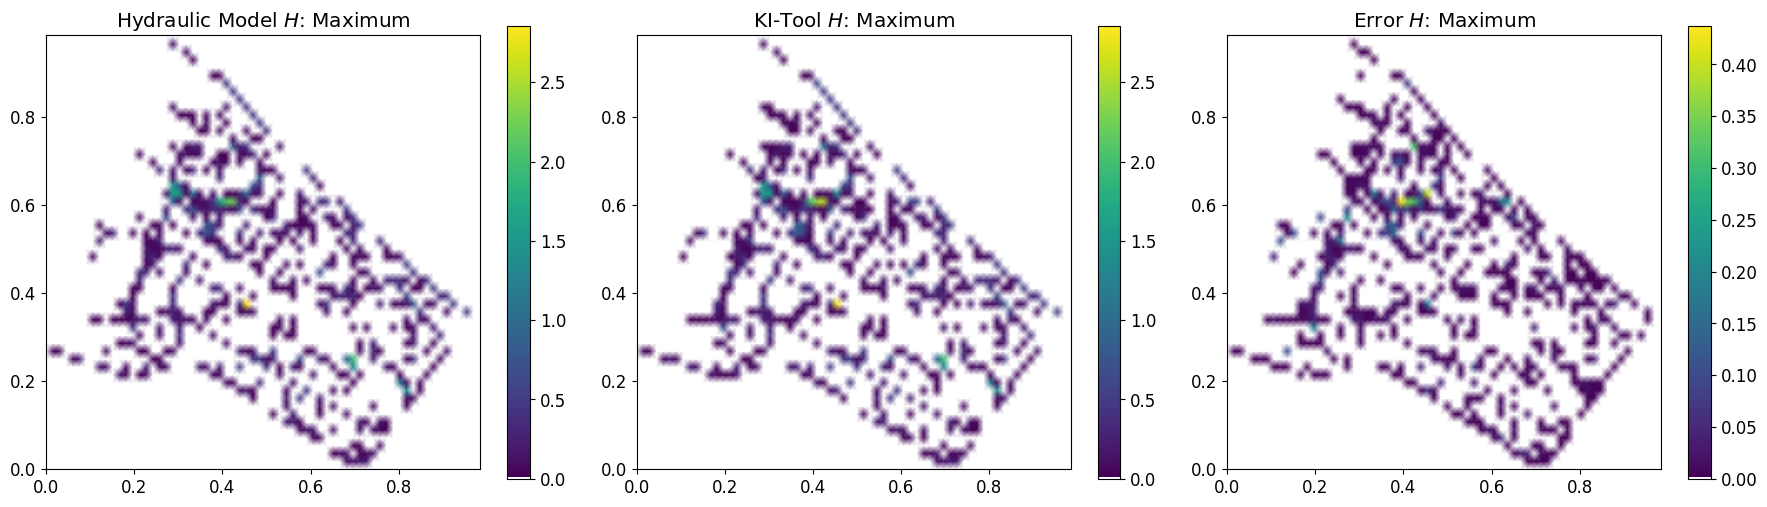

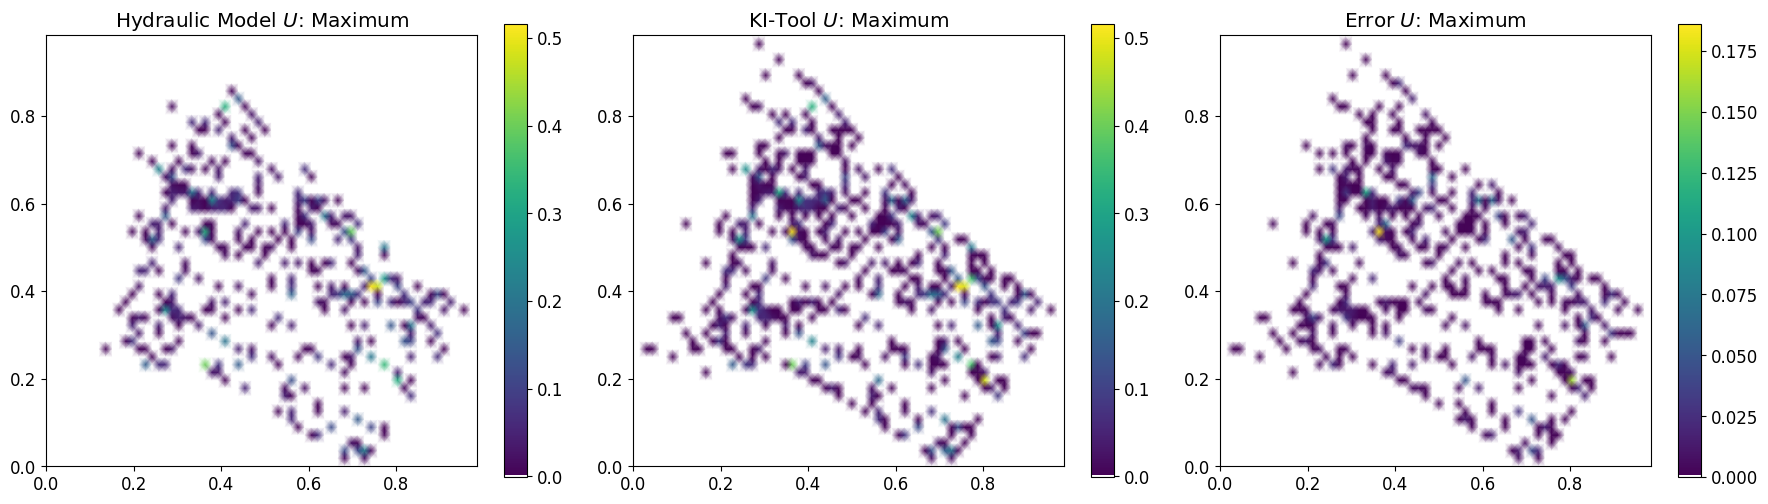

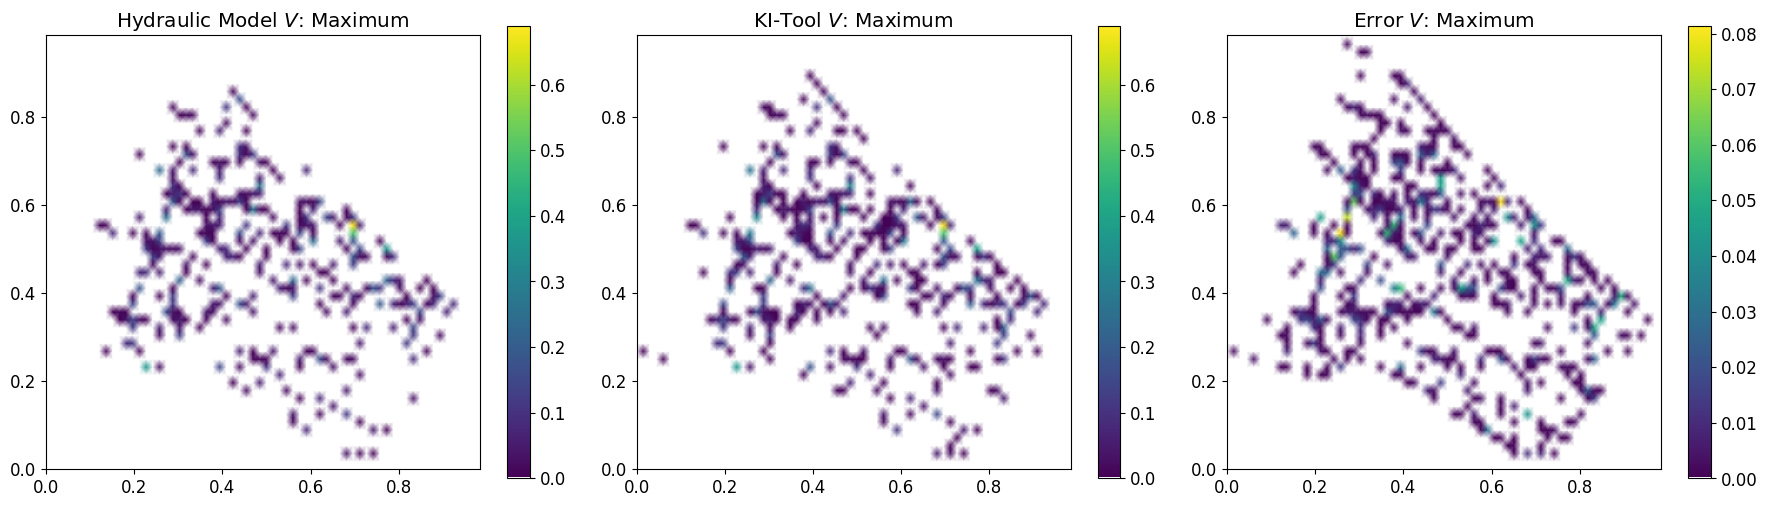

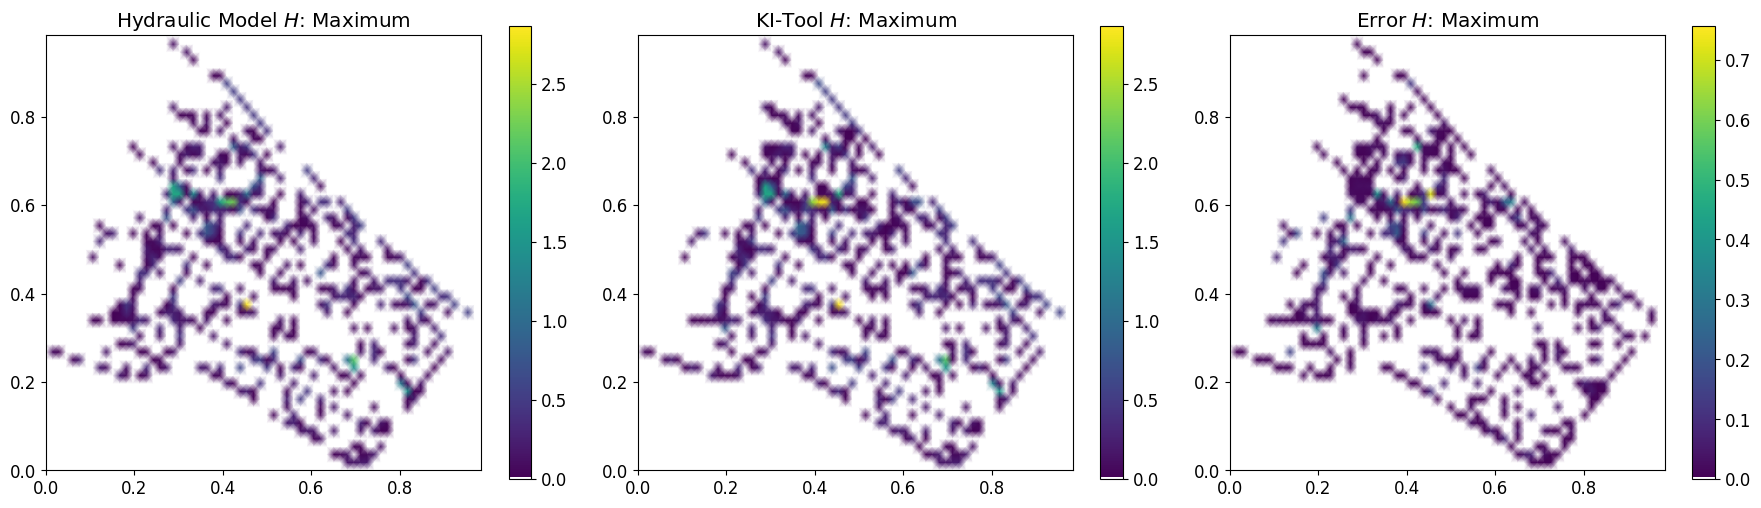

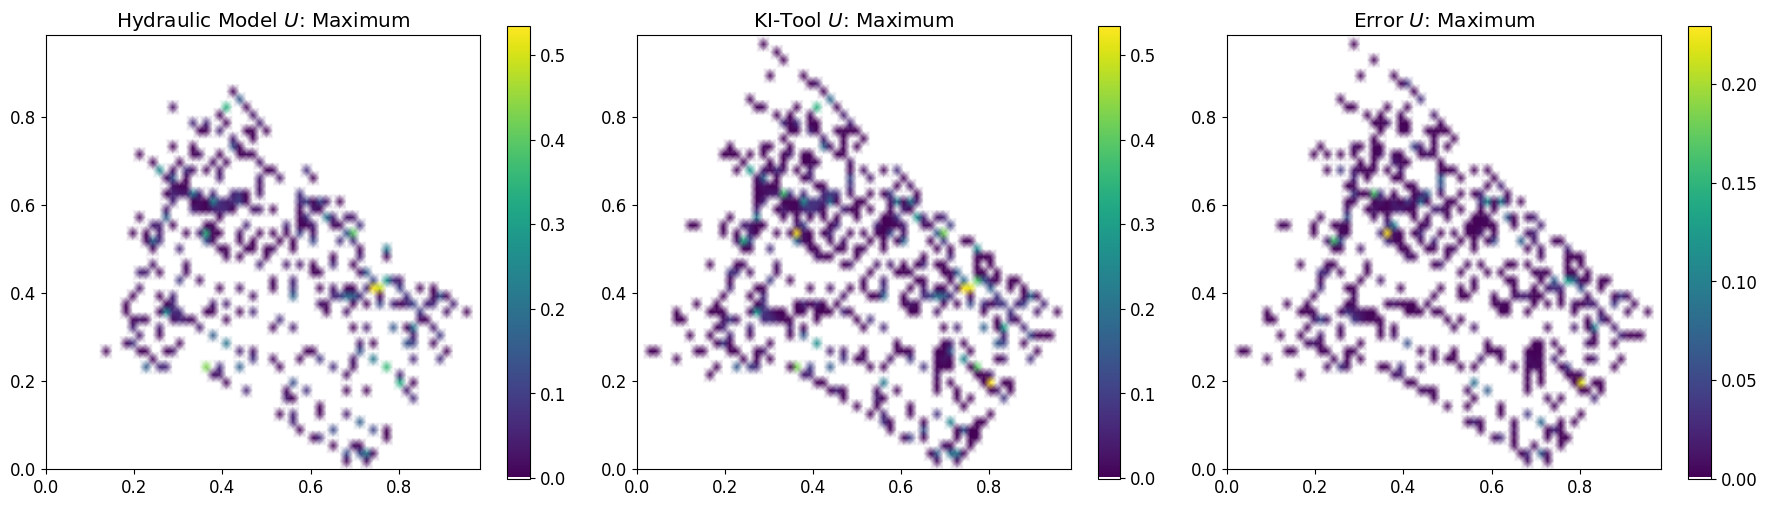

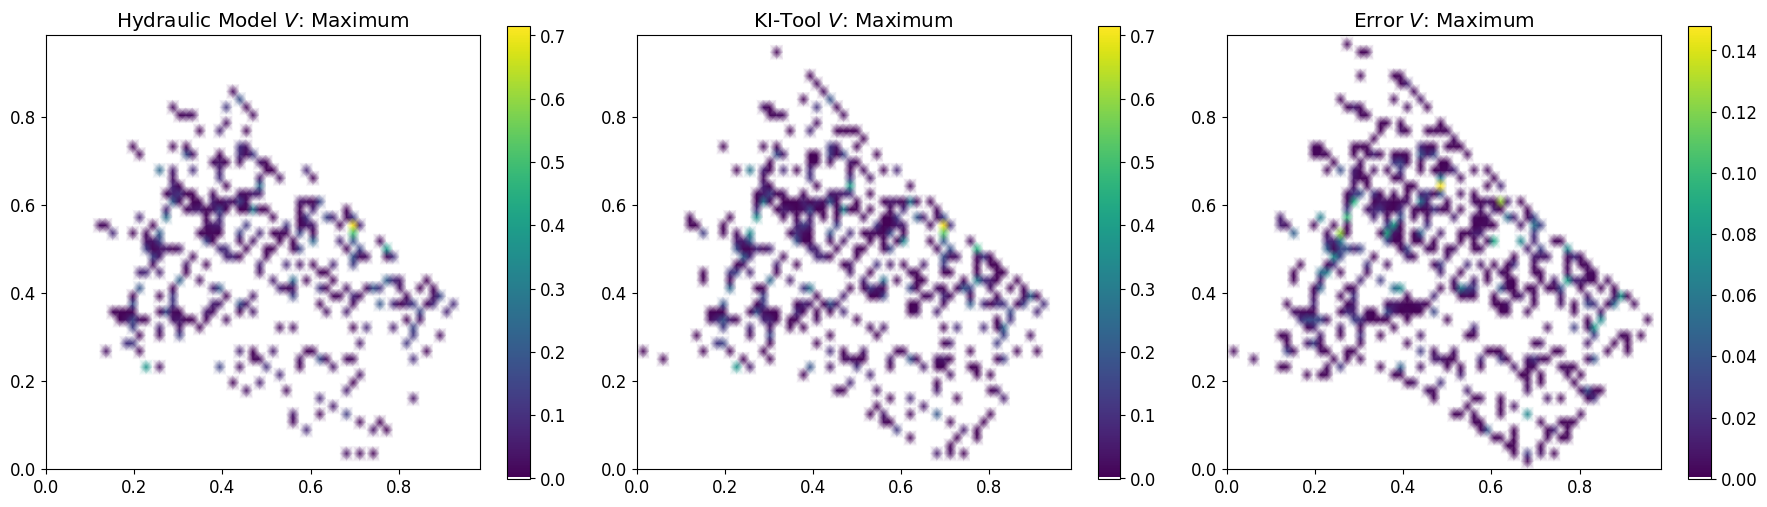

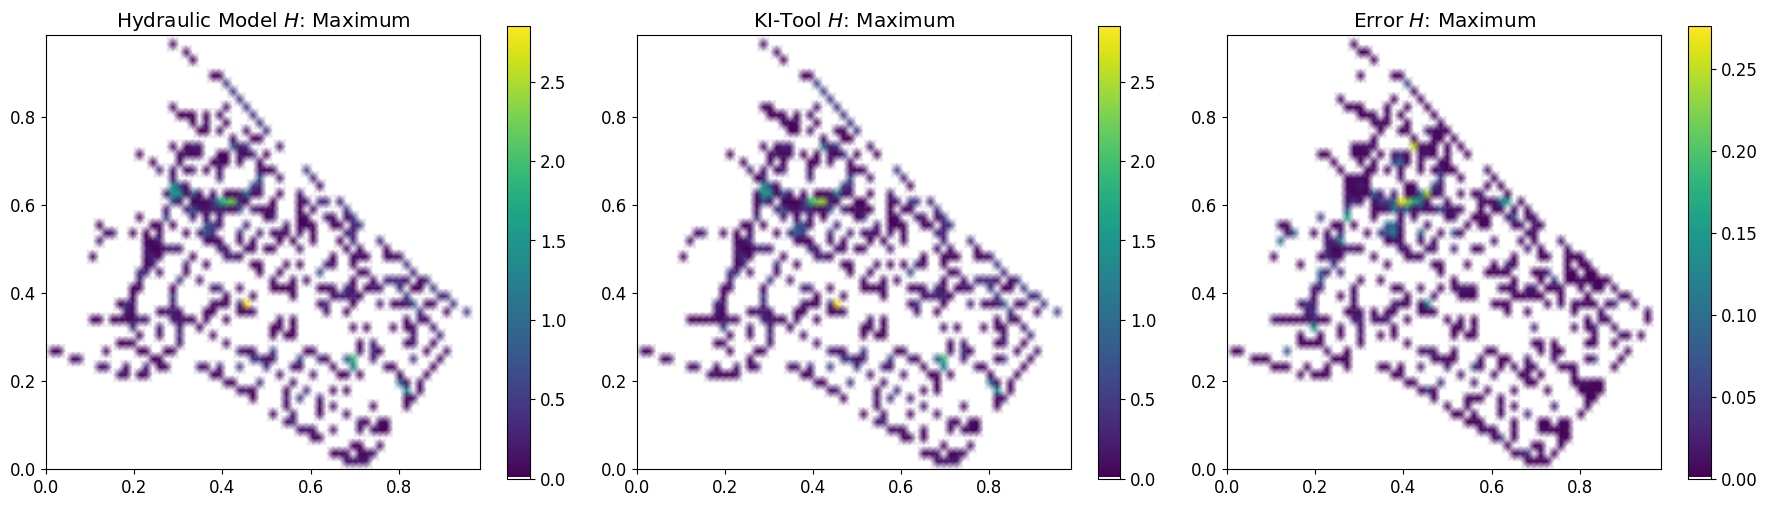

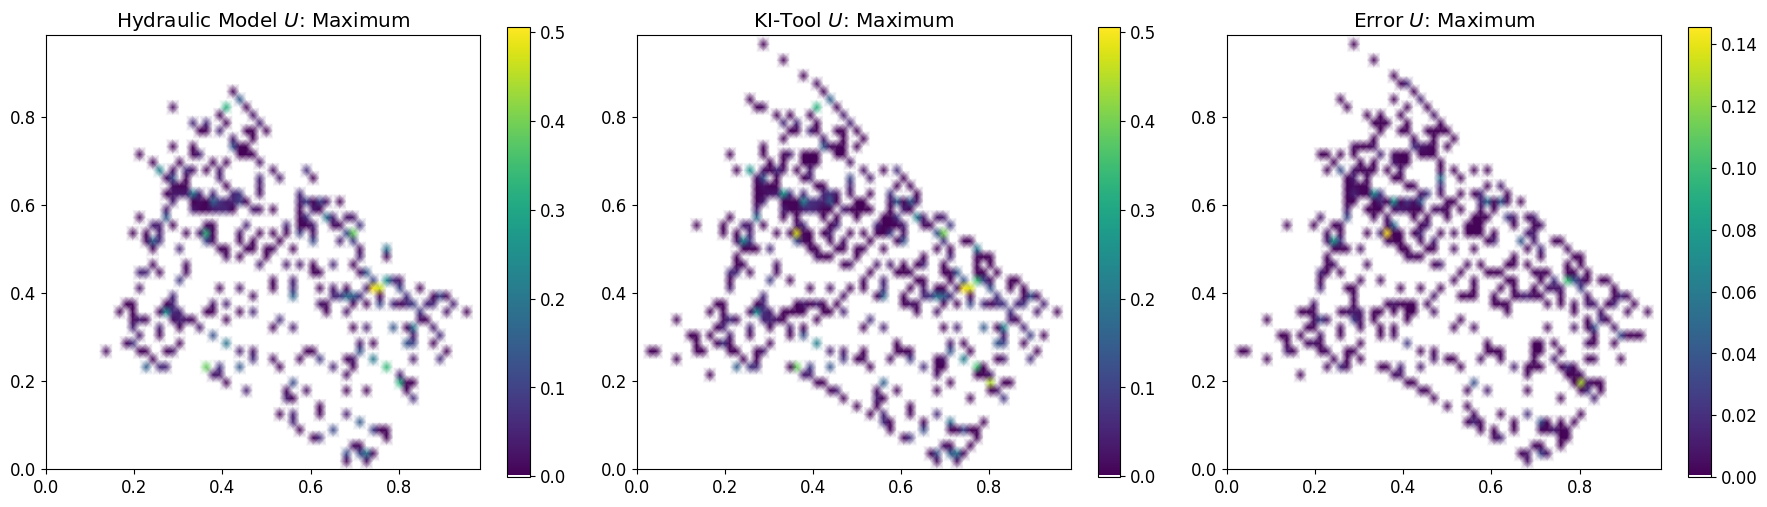

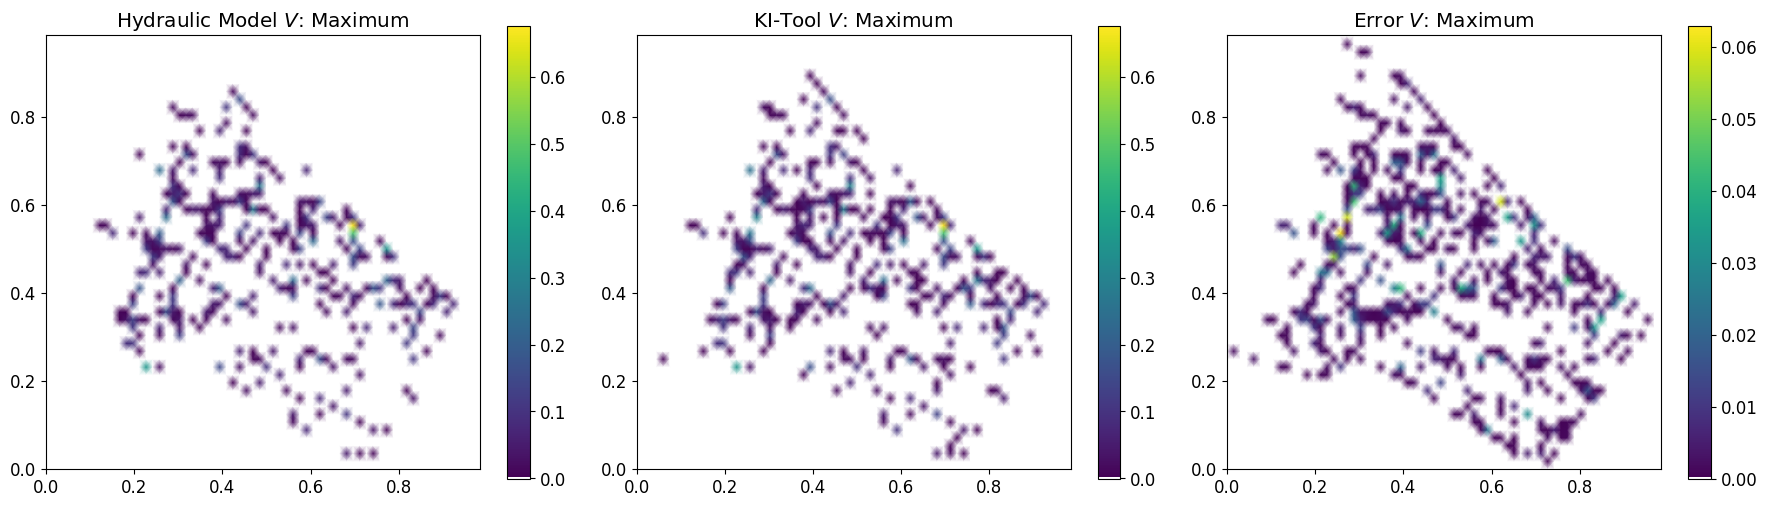

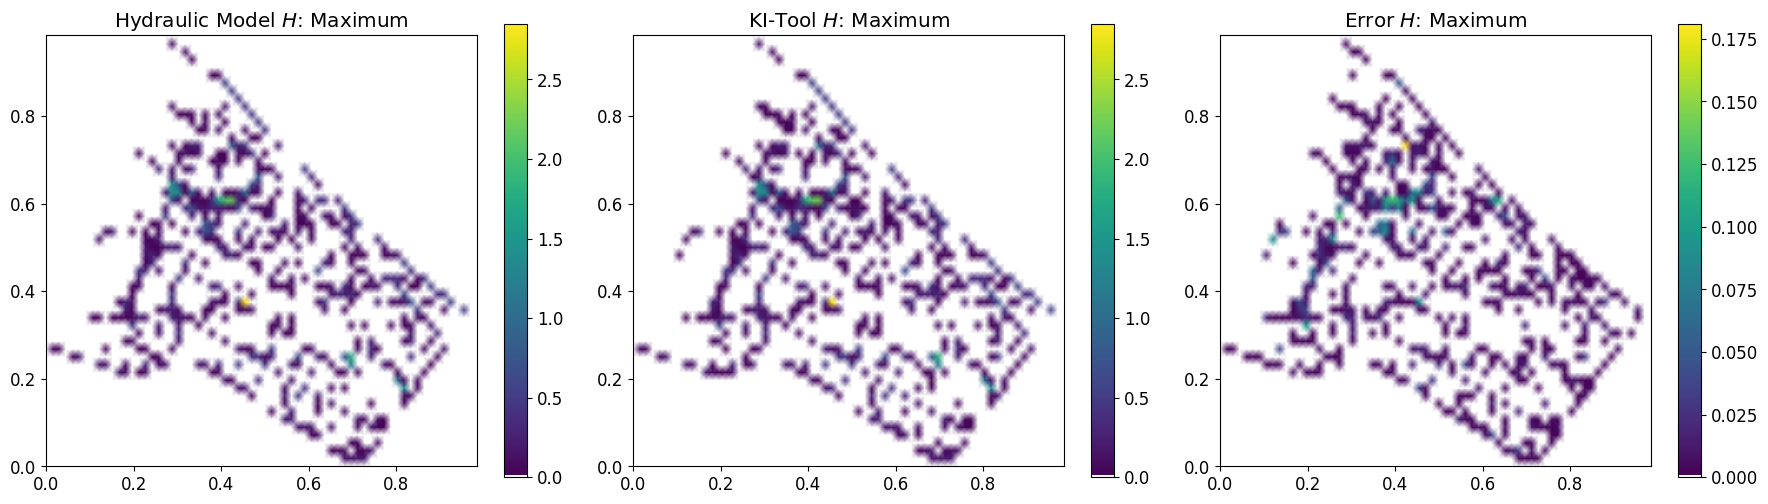

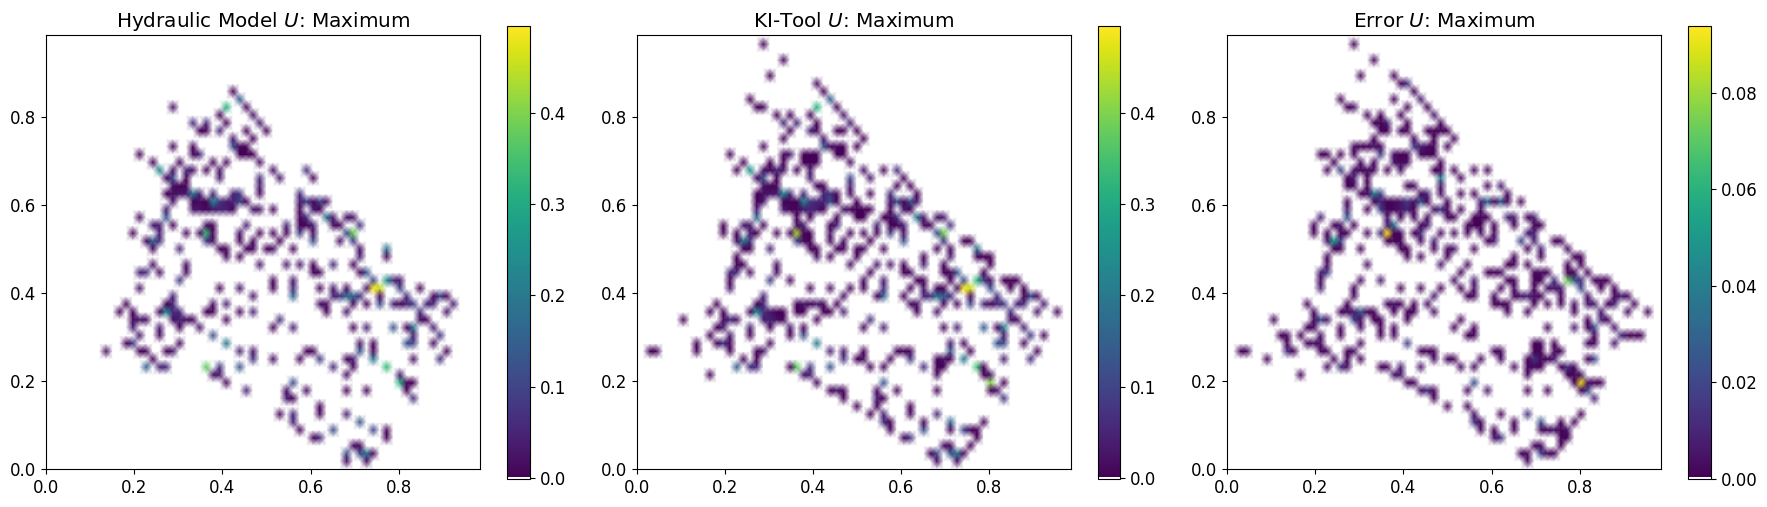

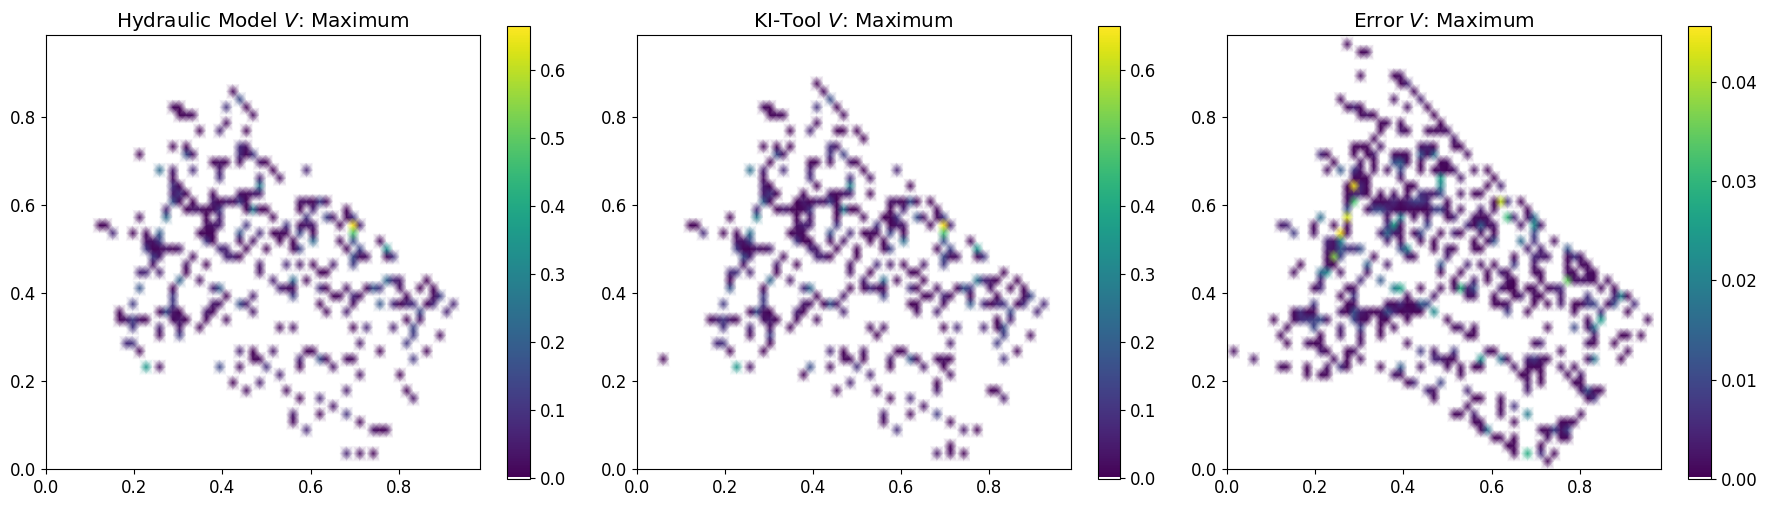

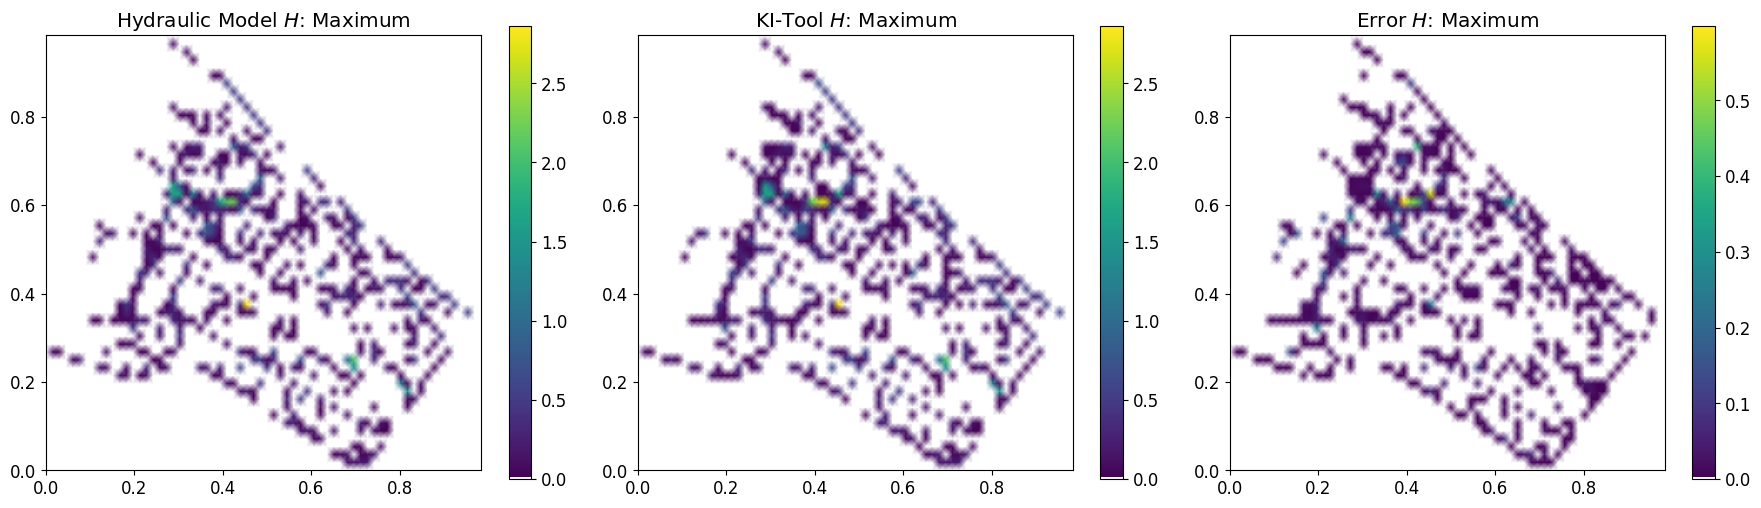

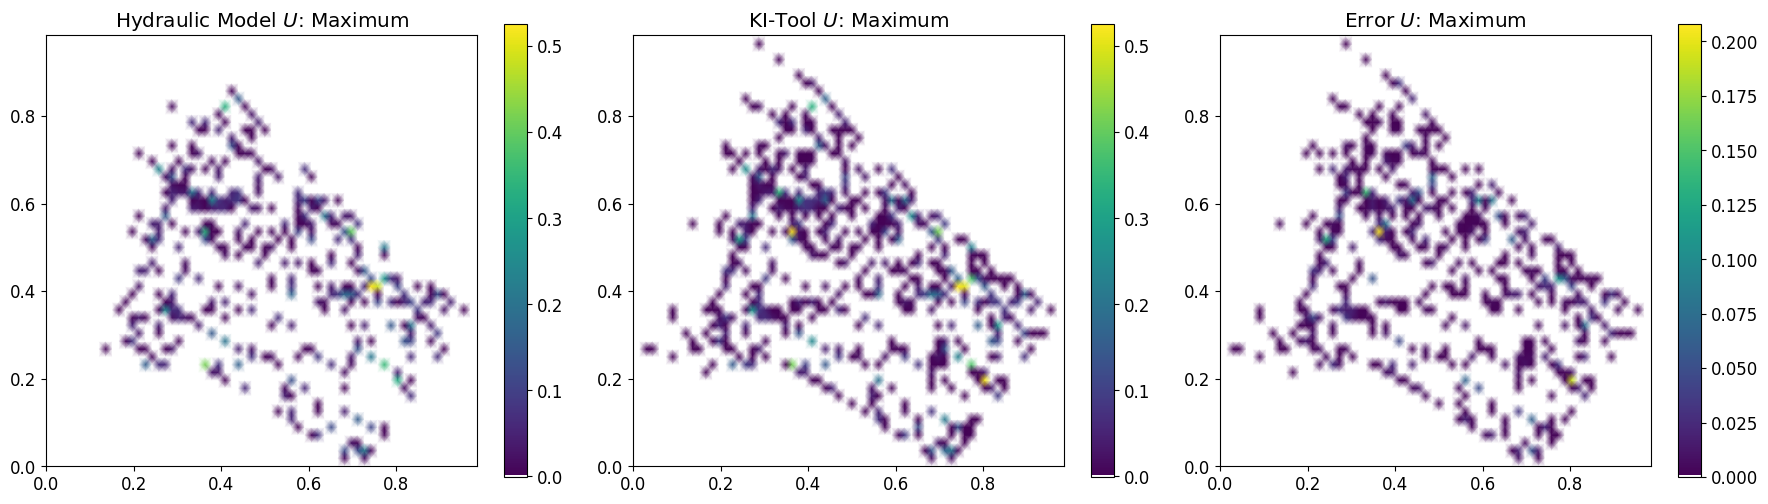

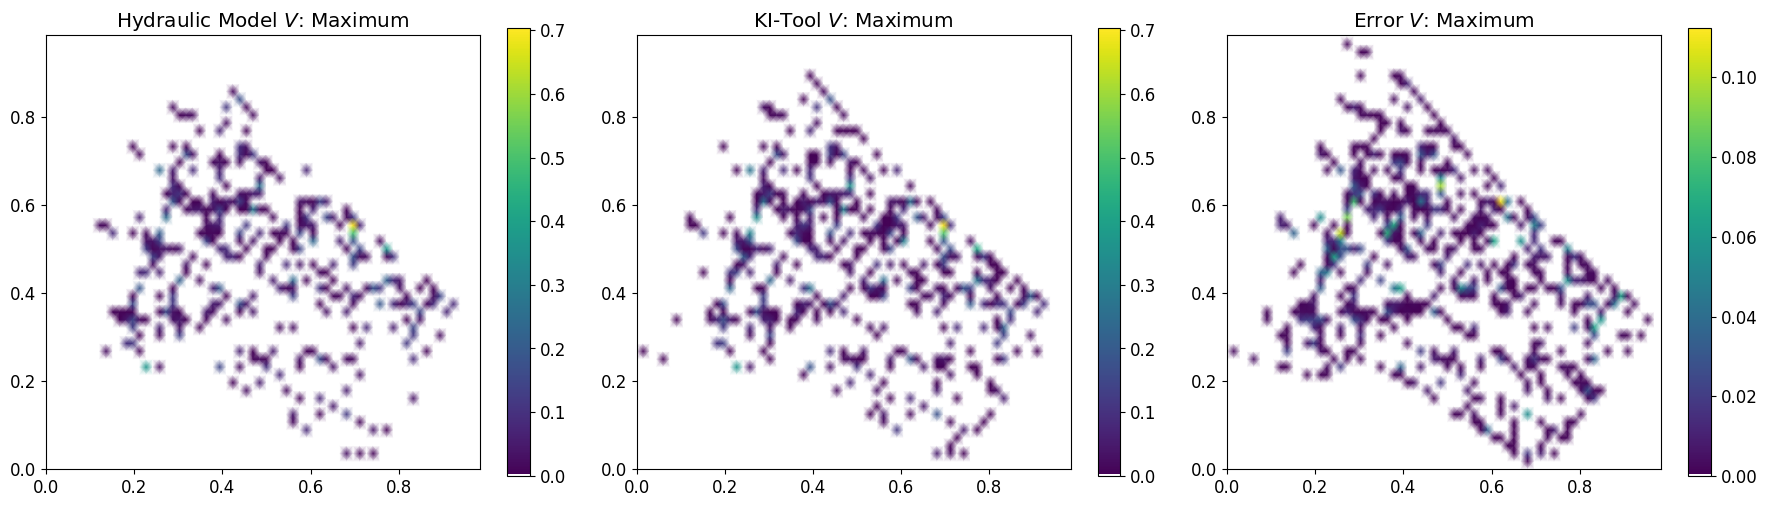

In [7]:

import os
if __name__ == '__main__':
    os.makedirs(Root_path, exist_ok=True)
    train()